# Integrated CA ML for Business and Data Visualisation

In [184]:
#!pip install jupyter_dash
#!pip install dash

In [185]:
#General
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output


# Time Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt


# Text Analytics
import sklearn.feature_extraction.text as sk_txt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [186]:
df = pd.read_csv('FACEBOOK_REVIEWS.csv')

# Data Pre-Processing

In [187]:
df.head()

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,0,baecdfaa-fdcf-4ec2-8795-f9e1d0885c3a,167801889669597203549,Om******hy,bad app,1,0,318.0.0.39.154,2021-05-19 20:00:27
1,1,12e913d6-105e-4f0c-bb22-4f6a0561cb18,318460545610239421517,Sa****************ol,Really really annoying app ... like if its not...,1,0,317.0.0.51.119,2021-05-19 20:00:29
2,2,7db12237-0f42-4ef7-873b-99495d575331,530587565711923101092,Ca*********04,Cunsurinimo,1,0,293.0.0.43.120,2021-05-19 20:00:29
3,3,6d48f3e8-54c4-417a-83c9-6b198ef7c516,413352731163292273792,Ar**************07,Bad experience,1,0,318.0.0.39.154,2021-05-19 20:00:30
4,4,c4430a84-d74b-4e24-8ed6-1e28110a355b,972610065867074567951,Ab***********kh,Totally pathetic experience too many ads and b...,1,0,308.0.0.42.118,2021-05-19 20:00:30


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2994736 entries, 0 to 2994735
Data columns (total 9 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   Unnamed: 0          int64 
 1   review_id           object
 2   pseudo_author_id    object
 3   author_name         object
 4   review_text         object
 5   review_rating       int64 
 6   review_likes        int64 
 7   author_app_version  object
 8   review_timestamp    object
dtypes: int64(3), object(6)
memory usage: 205.6+ MB


In [189]:
df.columns

Index(['Unnamed: 0', 'review_id', 'pseudo_author_id', 'author_name',
       'review_text', 'review_rating', 'review_likes', 'author_app_version',
       'review_timestamp'],
      dtype='object')

In [190]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [191]:
df['review_timestamp'] = pd.to_datetime(df['review_timestamp'])

In [192]:
df['review_timestamp'].min(), df['review_timestamp'].max()

(Timestamp('2021-05-19 20:00:27'), Timestamp('2023-11-13 23:23:21'))

In [193]:
df.isna().sum()

review_id                  0
pseudo_author_id           0
author_name                0
review_text              450
review_rating              0
review_likes               0
author_app_version    652863
review_timestamp           0
dtype: int64

In [194]:
df.dropna(inplace=True)
df.isna().sum()

review_id             0
pseudo_author_id      0
author_name           0
review_text           0
review_rating         0
review_likes          0
author_app_version    0
review_timestamp      0
dtype: int64

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2341493 entries, 0 to 2994735
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   review_id           object        
 1   pseudo_author_id    object        
 2   author_name         object        
 3   review_text         object        
 4   review_rating       int64         
 5   review_likes        int64         
 6   author_app_version  object        
 7   review_timestamp    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 160.8+ MB


## Data Visualisation Part 1

In [196]:
df.describe()

,review_rating,review_likes,review_timestamp
count,2.341493e+06,2.341493e+06,2341493
mean,2.937783e+00,3.510604e+00,2022-04-28 22:59:44.241313536
min,1.000000e+00,0.000000e+00,2021-05-19 20:00:27
25%,1.000000e+00,0.000000e+00,2021-07-16 10:22:16
50%,3.000000e+00,0.000000e+00,2022-02-25 19:34:50
75%,5.000000e+00,0.000000e+00,2022-12-23 00:22:33
max,5.000000e+00,8.418000e+04,2023-11-13 23:23:21
std,1.882540e+00,2.209054e+02,NaN


#### Histplot with the count of review ratings 

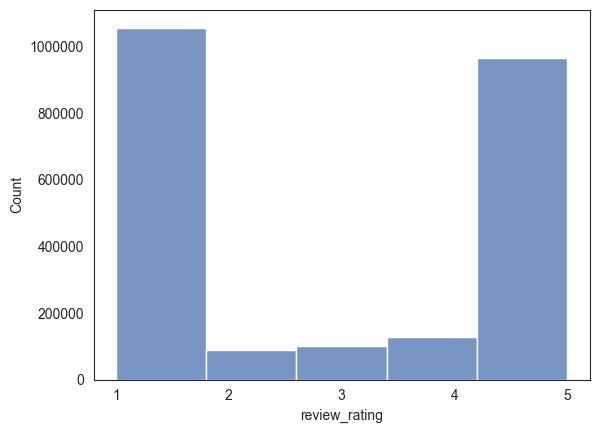

In [197]:
sns.set_style("white") 
sns.set_palette('deep') 
bins = list(set(df['review_rating'].unique()))
ax = sns.histplot(df['review_rating'], bins=5, kde=False)
plt.ticklabel_format(style='plain', axis='y')
ax.set_xticks(bins)
plt.show()

#### Bar Chart with count of review ratings per year

In [198]:
df['Year'] = df['review_timestamp'].dt.year
year = df.groupby(['Year','review_rating']).review_rating.value_counts().reset_index()

In [199]:
fig = px.bar(year,
            x= 'Year',
            y= 'count',
            color = 'review_rating',
            hover_data = {
                'count': ':,.0f'
            })
fig.show()

#### Scatterplot and Trendline with count of review likes by review rating

In [200]:
likes = df.groupby('review_rating')['review_likes'].sum().reset_index()

In [201]:
fig = px.scatter(likes,
         x='review_rating',
         y='review_likes',
         hover_data={
            'review_rating': ':,.f'
         },
         labels={
            'review_rating': 'Rating'
         },
         trendline='ols')
fig.show()

## Time Series Analysis

### Data Preprocessing for Time Series Analysis

In [202]:
df['year'] = df['review_timestamp'].dt.year
df_2022_23 = df[(df['year'] == 2022) | (df['year'] == 2023)]
df_2022_23['date']= df_2022_23['review_timestamp'].dt.date
df_2022_23['date'] = pd.to_datetime(df_2022_23['date'])
df_2022_23['date'] 


Feature creation "unique_reviews_per_day" that will be used for the time series.

In [205]:
unique_reviews_per_day = df_2022_23.groupby(['date'])['review_id'].nunique().reset_index(name='unique_reviews')
unique_reviews_per_day

,date,unique_reviews
0,2022-01-01,2029
1,2022-01-02,2208
2,2022-01-03,2013
3,2022-01-04,2081
4,2022-01-05,2234
...,...,...
677,2023-11-09,3204
678,2023-11-10,2501
679,2023-11-11,2146
680,2023-11-12,2207


plotting the feature 'unique_reviews_per_day' over time

<Axes: xlabel='date'>

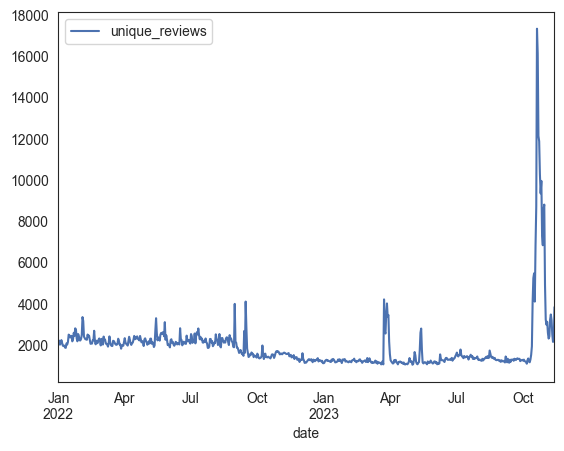

In [206]:
unique_reviews_per_day.plot(x="date", y="unique_reviews")

#### Augmented Dickey-Fuller Test

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In [295]:
adfuller(unique_reviews_per_day['unique_reviews'])
# p-value < 0.05, so we can reject the null hypothesis that the time series is non-stationary

(-4.557999606374601,
 0.0001542613892178854,
 12,
 669,
 {'1%': -3.4401625092086467,
  '5%': -2.865869922737958,
  '10%': -2.5690758278089465},
 10148.473746315094)

#### Finding the optimal Parameters

The ACF plot helps to identify the MA order (q), and the PACF plot helps to identify the AR order (p)

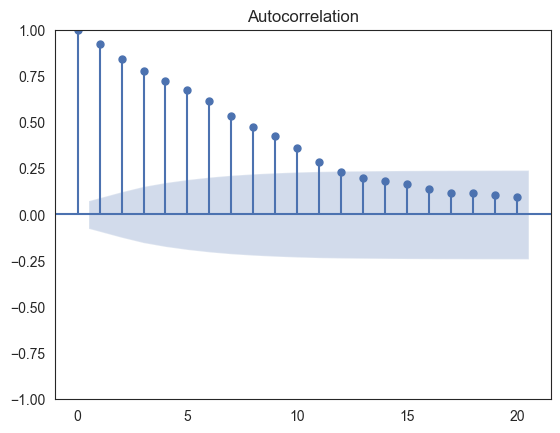

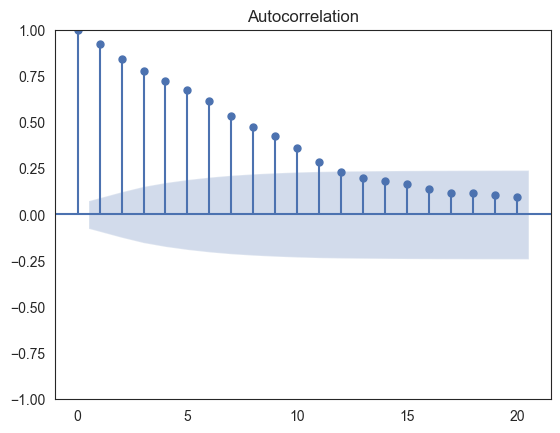

In [208]:
plot_acf(unique_reviews_per_day["unique_reviews"].dropna(),lags=20)
# q = has a significant coefficient until lag 10

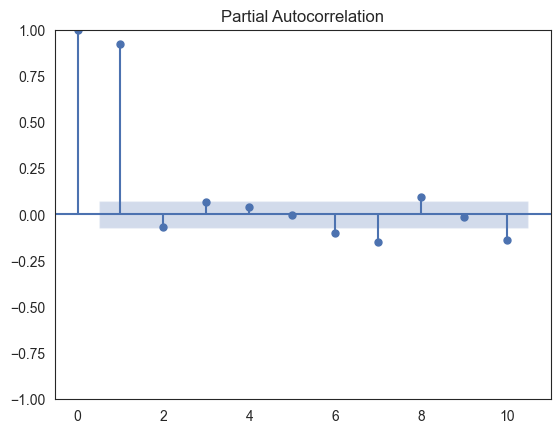

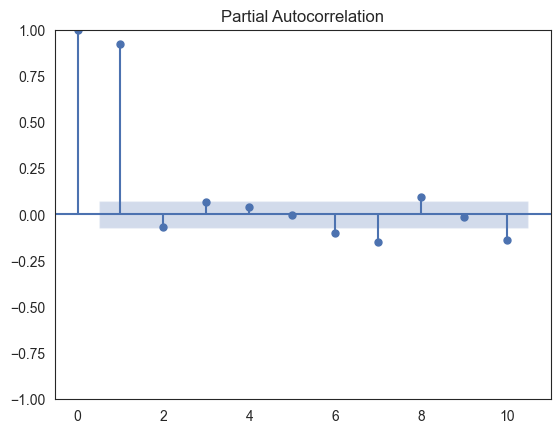

In [209]:
plot_pacf(unique_reviews_per_day["unique_reviews"].dropna(),lags=10)
# p = 1 has a significant correlation with the previous value

This code is performing a grid search to find the optimal parameters (p, d, q) for an ARIMA model based on the Akaike Information Criterion (AIC).

The ACF and PACF plots applied before are used to get an initial idea of what values of p and q to try. However, this grid search approach is a more systematic way to find the best parameters, as it tries out multiple combinations and selects the one with the lowest AIC.

In [210]:
from statsmodels.tsa.arima.model import ARIMA
aicVals = []
for p in range(0,1):
    p = 1
    for d in range(5):
        for q in range(1,5):
            print(p, d, q)
            
            try:
                aic = ARIMA(unique_reviews_per_day["unique_reviews"], order=(p, d, q)).fit().aic
                aicVals.append([aic, p, d, q])
            except np.linalg.LinAlgError:
                print(f"Unable to fit model for order=({p}, {d}, {q})")

1 0 1
1 0 2
1 0 3
1 0 4
1 1 1
1 1 2
1 1 3
1 1 4
1 2 1
1 2 2
1 2 3
1 2 4
1 3 1
1 3 2
1 3 3
1 3 4
1 4 1
1 4 2
1 4 3
1 4 4


## Initiate the ARIMA Model

In [262]:
model = ARIMA(unique_reviews_per_day["unique_reviews"], order=(1, 0, 2)).fit()

In [214]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unique_reviews   No. Observations:                  682
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -5248.061
Date:                Sun, 26 Nov 2023   AIC                          10506.122
Time:                        13:51:51   BIC                          10528.747
Sample:                             0   HQIC                         10514.878
                                - 682                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1903.8227    469.494      4.055      0.000     983.632    2824.013
ar.L1          0.9218      0.010     89.634      0.000       0.902       0.942
ma.L1          0.0774      0.023      3.386      0.001       0.033       0.122
ma.L2         -0.0635      0.018     -3.607      0.000      -0.098      -0.029
sigma2      2.853e+05   3424.831     83.295      0.000    2.79e+05    2.92e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            546961.68
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              12.41   Skew:                             8.03
Prob(H) (two-sided):                  0.00   Kurtosis:                       140.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Make Predictions

In [215]:
pred_time = 1 # predict 1 time step into the future
result = model.predict(start=unique_reviews_per_day["unique_reviews"].shape[0]-10, end=unique_reviews_per_day["unique_reviews"].shape[0] + pred_time).reset_index(drop=True)

In [263]:
result_plot = model.predict(start=unique_reviews_per_day["unique_reviews"].shape[0]-500, end=unique_reviews_per_day["unique_reviews"].shape[0]).reset_index(drop=True)

In [264]:
result_plot

0      2055.084990
1      2517.149107
2      2352.157221
3      2069.696883
4      2194.019570
          ...     
496    3074.562394
497    2417.527763
498    2142.499449
499    2205.541698
500    3805.022702
Name: predicted_mean, Length: 501, dtype: float64

In [217]:
result

0     3057.995561
1     2476.073400
2     2293.961294
3     2388.092856
4     3184.235493
5     3323.214417
6     3074.562394
7     2417.527763
8     2142.499449
9     2205.541698
10    3805.022702
11    3552.989405
Name: predicted_mean, dtype: float64

In [299]:
predictions = result.iloc[:-1]

In [316]:
actual_last10 = unique_reviews_per_day.tail(11).reset_index(drop=True)
actual_last500 = unique_reviews_per_day.tail(501).reset_index(drop=True)

#### Determine the forecast errors on seen data

In [300]:
rmse = sqrt(mean_squared_error(actual_last10['unique_reviews'], predictions))
r2 = r2_score(actual_last10['unique_reviews'], predictions)
print('Test RMSE: %.3f' % rmse)
print('Test R^2: %.3f' % r2)

Test RMSE: 77.063
Test R^2: 0.980


Creating new combined dataframes for table and plot in Dashboard (Data Visualisation Part 2)

In [298]:
# Combine result and actual_last10 into one DataFrame based on the index
combined_df_plot = pd.concat([result_plot, actual_last500], axis=1)
combined_df_plot = combined_df_plot[['date', 'unique_reviews', 'predicted_mean']]

In [220]:
# Combine result and actual_last10 into one DataFrame based on the index
combined_df = pd.concat([result, actual_last10], axis=1)
combined_df = combined_df[['date', 'unique_reviews', 'predicted_mean']]

# Round the values to the nearest integer
combined_df = combined_df.round(0)

# Replace the NaT value at index 11 with a specific date
combined_df.at[11, 'date'] = pd.to_datetime('2023-11-14')
combined_df

,date,unique_reviews,predicted_mean
0,2023-11-03,3123.0,3058.0
1,2023-11-04,2577.0,2476.0
2,2023-11-05,2308.0,2294.0
3,2023-11-06,2408.0,2388.0
4,2023-11-07,3230.0,3184.0
5,2023-11-08,3477.0,3323.0
6,2023-11-09,3204.0,3075.0
7,2023-11-10,2501.0,2418.0
8,2023-11-11,2146.0,2142.0
9,2023-11-12,2207.0,2206.0


#### Determine the forecast errors on unseen data

In [302]:
# Split into train and test sets
size = int(len(unique_reviews_per_day["unique_reviews"]) * 0.7)
train, test = unique_reviews_per_day["unique_reviews"][0:size], unique_reviews_per_day["unique_reviews"][size:len(unique_reviews_per_day)]

In [303]:
train.shape, test.shape

((477,), (205,))

In [304]:
model = ARIMA(train, order=(1, 0, 2)).fit()

In [305]:
# Make predictions
predict = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# test predictions
rmse = sqrt(mean_squared_error(test, predict))
r2 = r2_score(test, predict)

print('Test RMSE: %.3f' % rmse)
print('Test R^2: %.3f' % r2)

Test RMSE: 2394.323
Test R^2: -0.001


The model has produced unsatisfactory results on unseen data. Another data manipulation step is required to solve this problem.

#### Removing Outliers

Data points outside Q1 and Q3 times 1.5 the IQR were disregarded.

In [228]:
Q1 = unique_reviews_per_day['unique_reviews'].quantile(0.25)
Q3 = unique_reviews_per_day['unique_reviews'].quantile(0.75)
IQR = Q3 - Q1

# Create a new DataFrame excluding outliers
df_clean = unique_reviews_per_day[~((unique_reviews_per_day['unique_reviews'] < (Q1 - 1.5 * IQR)) |(unique_reviews_per_day['unique_reviews'] > (Q3 + 1.5 * IQR)))]
df_clean

,date,unique_reviews
0,2022-01-01,2029
1,2022-01-02,2208
2,2022-01-03,2013
3,2022-01-04,2081
4,2022-01-05,2234
...,...,...
676,2023-11-08,3477
677,2023-11-09,3204
678,2023-11-10,2501
679,2023-11-11,2146


#### Plotting the treated target variable

<Axes: xlabel='date'>

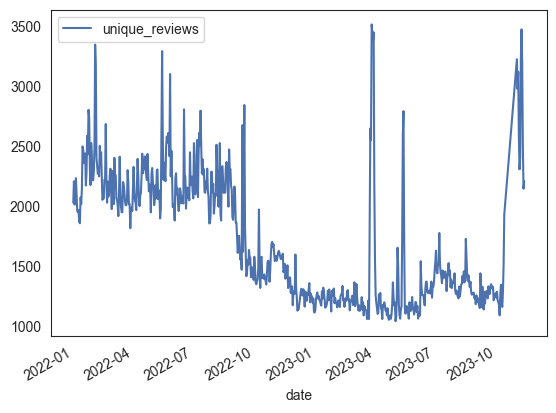

In [229]:
df_clean.plot(x="date", y="unique_reviews")

In [230]:
adfuller(df_clean['unique_reviews'])
# p-value < 0.05, so we can reject the null hypothesis that the data is not stationary

(-2.9924609451006674,
 0.03560447657612157,
 5,
 653,
 {'1%': -3.4404038931945276,
  '5%': -2.865976260062519,
  '10%': -2.5691324834372633},
 8674.567330975071)

In [231]:
# Split into train and test sets
train_size = int(len(df_clean["unique_reviews"]) * 0.7)
train, test = df_clean["unique_reviews"][0:train_size], df_clean["unique_reviews"][train_size:len(df_clean)]

In [232]:
train.shape, test.shape

((461,), (198,))

### Fit the Processed Data to the Model

In [233]:
# Fit the model
model = ARIMA(train, order=(2, 1, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unique_reviews   No. Observations:                  461
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3129.534
Date:                Sun, 26 Nov 2023   AIC                           6267.068
Time:                        13:52:07   BIC                           6283.592
Sample:                             0   HQIC                          6273.575
                                - 461                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5928      0.030     19.853      0.000       0.534       0.651
ar.L2          0.1172      0.026      4.518      0.000       0.066       0.168
ma.L1         -0.9553      0.021    -44.567      0.000      -0.997      -0.913
sigma2       4.74e+04   1370.824     34.576      0.000    4.47e+04    5.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              2900.51
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             2.00
Prob(H) (two-sided):                  0.89   Kurtosis:                        14.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Evaluation

In [234]:
predictions = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

mae = mean_absolute_error(test, predictions)
print('Test MAE: %.2f'% mae)

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test MAE: 254.83
Test RMSE: 422.032


In [235]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test, predictions)
print('Test MAPE: %.2f' % mape)

Test MAPE: 16.46


## Text Analytics

In [236]:
df

,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,Year,year
0,baecdfaa-fdcf-4ec2-8795-f9e1d0885c3a,167801889669597203549,Om******hy,bad app,1,0,318.0.0.39.154,2021-05-19 20:00:27,2021,2021
1,12e913d6-105e-4f0c-bb22-4f6a0561cb18,318460545610239421517,Sa****************ol,Really really annoying app ... like if its not...,1,0,317.0.0.51.119,2021-05-19 20:00:29,2021,2021
2,7db12237-0f42-4ef7-873b-99495d575331,530587565711923101092,Ca*********04,Cunsurinimo,1,0,293.0.0.43.120,2021-05-19 20:00:29,2021,2021
3,6d48f3e8-54c4-417a-83c9-6b198ef7c516,413352731163292273792,Ar**************07,Bad experience,1,0,318.0.0.39.154,2021-05-19 20:00:30,2021,2021
4,c4430a84-d74b-4e24-8ed6-1e28110a355b,972610065867074567951,Ab***********kh,Totally pathetic experience too many ads and b...,1,0,308.0.0.42.118,2021-05-19 20:00:30,2021,2021
...,...,...,...,...,...,...,...,...,...,...
2994731,f01698fa-5056-4199-b88f-d294050062cb,272225995443346295413,Ji**********ur,eed Red; Red raCCC !duxiixiuz En do,1,0,440.0.0.31.105,2023-11-13 23:20:59,2023,2023
2994732,796fa280-6530-49dc-bc7d-f93ae086b31d,147368069644520083993,A Google user,Not been working all day and no update availab...,1,0,440.0.0.31.105,2023-11-13 23:21:20,2023,2023
2994733,b31e8e70-4e3b-419b-aa2f-a8a3f5a0bd05,257906640422320735099,Wa***********em,Absolute bias towards Israel,1,0,436.0.0.35.101,2023-11-13 23:21:26,2023,2023
2994734,a229e971-5a99-47c7-bf07-48ca9c8ed491,180604354313420497079,Na********ed,لا حريه ف التعبر,1,0,438.0.0.33.118,2023-11-13 23:21:31,2023,2023


In [237]:
#pip install langdetect
#pip install nltk

#### Clean Data and Create smaller Sample to save computational cost 

In [238]:
df = df[df['year'] == 2023]
df['review_text'] = df['review_text'].dropna()
df['review_text'] = df['review_text'].astype(str)

In [276]:
# Set the sample size and select a random sample of reviews
sample_size = 50000

df_sample = df.sample(n=sample_size, random_state=1)

In [279]:
df_sample['review_text']

2546349                      Nabil Haider 5k follower please
2931659    Very unfair to Palestinian n posting about pal...
2890682                                           👎🏻👎🏻👎🏻👎🏻👎🏻
2361762    Can't even open reels, I keep taping and tapin...
2543365                                                 Good
                                 ...                        
2564902                                           Nice app 👌
2825708    تطبيق لايحترم حرية التعبير ولايحترم خصوصيات ال...
2858266                          من أجل المسجد الأقصى الأسير
2700672                                         Rakeshkumar.
2286913                          Tyybh hi ht it uuuiu7yo. Ll
Name: review_text, Length: 50000, dtype: object

#### Download packages

In [244]:
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer
import string



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johannes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johannes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Text preprocessing

In [280]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in df_sample['review_text']]
doc_clean

[['nabil', 'haider', '5k', 'follower', 'please'],
 ['unfair',
  'palestinian',
  'n',
  'posting',
  'palestine',
  'always',
  'vanish',
  'please',
  'neutral'],
 ['👎🏻👎🏻👎🏻👎🏻👎🏻'],
 ['cant', 'even', 'open', 'reel', 'keep', 'taping', 'taping', 'open'],
 ['good'],
 ['updating', 'application', 'slowly', 'mobile', 'lag', 'login'],
 ['good'],
 ['biased', 'palestinian', 'muslim', 'disappointing'],
 ['nice'],
 ['excellent'],
 ['thank'],
 ['পমনো'],
 ['good', 'application', 'recommend', 'anyone'],
 ['nice', 'app'],
 ['👎'],
 ['unfair', 'whats', 'happening', 'gaza'],
 ['ok'],
 ['auto',
  'friend',
  'request',
  'keep',
  'bothering',
  'me',
  'lately',
  'facebook',
  'keep',
  'crashing',
  'cant',
  'even',
  'comment',
  'watch',
  'something',
  'without',
  'facebook',
  'crashing',
  '247',
  'even',
  'touchedclicked',
  'facebook',
  'profile',
  'auto',
  'request',
  'someone',
  'cant',
  'reccomend',
  'bug',
  'like',
  'now',
  'come',
  'back'],
 ['precise', 'tuner'],
 ['panget',

#### Vectorize text data and assign Topics

In [288]:
# Vectorization
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
X = vectorizer.fit_transform([' '.join(doc) for doc in doc_clean])

# LDA Model Training
lda_model = LatentDirichletAllocation(n_components=4, random_state=0)
lda_model.fit(X)

# Assigning Topics
topic_results = lda_model.transform(X)
df_sample['Topic'] = topic_results.argmax(axis=1)
df_sample['Topic']

0        0
1        1
2        0
3        0
4        3
        ..
49995    2
49996    2
49997    2
49998    0
49999    1
Name: Topic, Length: 50000, dtype: int64

In [289]:
print(df_sample[df_sample['Topic'] == 0]['review_text'])

0                 Nabil Haider 5k follower please
2                                   Excillent App
3        face book don't let me share my opinions
5                              8u zxc3,reuyh y, N
10                 Gone to poop. Tictoc is better
                           ...                   
49987                                    Nice app
49988                          Entertainment Savy
49990                                   Muito bom
49994                                        Good
49998                                        Good
Name: review_text, Length: 21733, dtype: object


#### Split into Test and Training Set

In [290]:
y = df_sample['Topic']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 3680), (10000, 3680), (40000,), (10000,))

### Model Evaluation

In [291]:
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      4370
           1       0.94      0.89      0.91      1666
           2       0.98      0.96      0.97      1805
           3       0.94      0.92      0.93      2159

    accuracy                           0.94     10000
   macro avg       0.95      0.93      0.94     10000
weighted avg       0.94      0.94      0.94     10000



## Data Visualisation Part 2

Create date feature for df_sample data frame

In [285]:
df_sample = df_sample.sort_values(by='Topic', ascending=True).reset_index(drop=True)
df_sample['date']= df_sample['review_timestamp'].dt.date
df_sample['date'] = pd.to_datetime(df_sample['date'])
df_sample

,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,Year,year,Topic,date
0,5e2133a2-340c-42a3-8233-6c670354e9d1,270161967632645539966,sa******bd,Nabil Haider 5k follower please,5,0,417.0.0.33.65,2023-06-10 23:34:22,2023,2023,0,2023-06-10
1,7fc087f6-df8a-479f-9da0-f247f41d5a47,177655881469465946041,Sk********ry,It is very important for yourself,5,0,396.1.0.28.104,2023-01-01 22:28:15,2023,2023,0,2023-01-01
2,86102fb9-e2d7-4817-baf1-3da28e32f00c,286635446193937429108,Ma***********in,Excillent App,5,0,414.0.0.30.113,2023-05-13 05:20:43,2023,2023,0,2023-05-13
3,2fa601b0-2d7f-45bb-8b84-a878adbe044c,314362603893424499660,As********ri,face book don't let me share my opinions,1,1,436.0.0.35.101,2023-10-30 00:41:31,2023,2023,0,2023-10-30
4,916864ed-9053-4585-a3fb-4add770fffd9,269815818439516019658,Na******li,NadeemAli,5,0,194.0.0.42.99,2023-02-03 21:38:14,2023,2023,0,2023-02-03
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,f8365279-3e07-4d76-b01e-ca885943ee4b,313499606821167085267,Jo*****ck,Very useful,5,0,386.0.0.35.108,2023-01-09 19:13:02,2023,2023,4,2023-01-09
49996,9109049a-93fc-476c-9f98-69797a7fa8ad,179106145525060996606,Mu***********al,nice app,5,0,398.0.0.21.105,2023-04-04 15:59:23,2023,2023,4,2023-04-04
49997,3ebd553e-f737-4c24-a970-3ce065b22bed,271184173395480047732,xa**** e,Good,5,0,332.0.0.23.111,2023-04-10 21:29:23,2023,2023,4,2023-04-10
49998,9fd4488d-98c4-4710-8012-f93fad96b53f,138780667629969574508,সু***াল,Good,5,0,409.0.0.27.106,2023-04-12 02:03:00,2023,2023,4,2023-04-12


#### Plot count of Documents per Topic

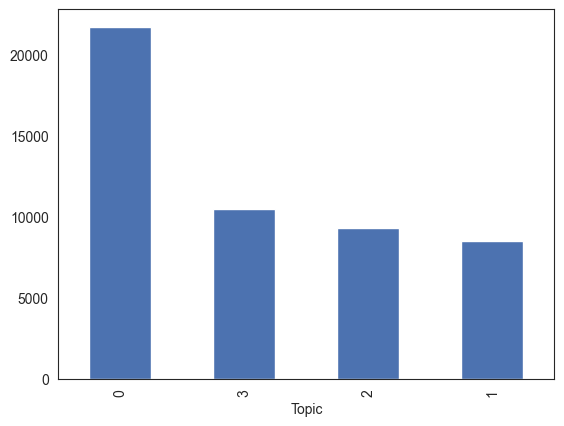

In [292]:
topic_counts = df_sample['Topic'].value_counts()
# Create a bar plot
topic_counts.plot(kind='bar')

# Show the plot
plt.show()

## Interactive Dashboard

In [252]:
#!pip install panel
#pip install hvplot
#pip install jupyter_bokeh

In [ ]:
# Define the interactive components
topic_selector = pn.widgets.Select(name='Topic', options=list(df_sample['Topic'].unique()))

# Create a function for the table
def create_table():
    # Create a table from the combined_df DataFrame
    table = pn.widgets.DataFrame(combined_df)
    return pn.Column(pn.pane.Markdown("# Time Series (Table)"), pn.pane.Markdown("The table displays the ARIMA model's predictions for the last 10 observations (including one step into the future) against the last 10 actual observations."), table)

# Define the plots
@pn.depends(topic_selector.param.value)
def plot_data(topic):
    df_topic = df_sample[df_sample['Topic'] == topic]
    
    # plots related to Topic (from Text Analytics)
    dynamic_plot1 = df_topic.hvplot.bar('review_rating', 'review_likes')
    dynamic_plot2 = df_topic.hvplot.line('date','review_likes')
    static_plot1 = df_sample.hvplot.box('review_likes', 'Topic') 

    # plots related to unique_reviews_per_day (from Time Series)
    static_plot2 = unique_reviews_per_day.hvplot(x="date", y="unique_reviews")
    static_plot3 = combined_df_plot.hvplot(x="date", y=["unique_reviews", "predicted_mean"])
  
    # combining the plots into a layout
    text_analytics_plots = pn.Column(pn.pane.Markdown("# Text Analytics"), pn.pane.Markdown("Please us the dropdown menu to choose the topic you want to explore"), topic_selector, pn.pane.Markdown("### Bar Chart (review likes by review rating)"), dynamic_plot1,pn.pane.Markdown("The above plot shows the distribution of the frequency of obs between different ratings"), pn.pane.Markdown("### Line Chart (review likes per day)"), dynamic_plot2,pn.pane.Markdown("There is some peaks at certain timestamps depending on the Topic selected"), pn.pane.Markdown("### Boxplot (review likes by topic)"), static_plot1, pn.pane.Markdown("The above plot shows the distribution of the frequency of obs (likes) between different topics. Topic 0 was found to have the highest median likes among all four topics."))
    time_series_plot = pn.Column(pn.pane.Markdown("# Time Series (Plots)"), pn.pane.Markdown("The below are visualisations of the time series data used for this research project."),pn.pane.Markdown("### Line Chart (actual observations)"), static_plot2, pn.pane.Markdown("### Line Chart (actual obs vs. predicted)"), static_plot3, pn.pane.Markdown("The model is able to accurately predict the trend as well as the seasonality and even the noise of the time series data. Note that the model only performed so well because it was trained on the entire dataset."))
    return pn.Row(text_analytics_plots, time_series_plot)

# Combine the components into a layout
dashboard = pn.Row(plot_data, create_table())

dashboard.show()

Launching server at http://localhost:58142


2023-11-26 23:28:40,186 ERROR: panel.reactive - Callback failed for object named "Topic" changing property {'value': 3} 
Traceback (most recent call last):
  File "/Users/johannes/opt/anaconda3/envs/new_environment/lib/python3.11/site-packages/panel/viewable.py", line 596, in _preprocess
    hook(self, root, changed, old_models)
TypeError: link_axes() takes 2 positional arguments but 4 were given

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/johannes/opt/anaconda3/envs/new_environment/lib/python3.11/site-packages/panel/reactive.py", line 385, in _process_events
    self.param.update(**self_events)
  File "/Users/johannes/opt/anaconda3/envs/new_environment/lib/python3.11/site-packages/param/parameterized.py", line 2282, in update
    restore = self_._update(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/johannes/opt/anaconda3/envs/new_environment/lib/python3.11/site-packages/param/par

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x10494ec10>>, <Task finished name='Task-391645' coro=<ServerSession.with_document_locked() done, defined at /Users/johannes/opt/anaconda3/envs/new_environment/lib/python3.11/site-packages/bokeh/server/session.py:77> exception=TypeError("The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>)")>)
Traceback (most recent call last):
  File "/Users/johannes/opt/anaconda3/envs/new_environment/lib/python3.11/site-packages/panel/viewable.py", line 596, in _preprocess
    hook(self, root, changed, old_models)
TypeError: link_axes() takes 2 positional a